# Model Training
Trains a model on past data.

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import os
print(os.getcwd())

import sys
sys.path.append('..\\..')
print(sys.path)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


c:\Users\User\AAAMio\Projects\riga-stock-nn\src\notebooks\stock_up_down
['c:\\Users\\User\\anaconda3\\envs\\pytorch\\python312.zip', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\DLLs', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib', 'c:\\Users\\User\\anaconda3\\envs\\pytorch', '', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\win32', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\Pythonwin', '..\\..', '..\\..']
Device: cuda


### SET PARAMETERS:


In [108]:
TICKER="TSLA"
DATA_INTERVAL_MINUTES = 15   # (Set to 5 or 15)
DATA_AFTER_HOURS = False

DAYS_PREDICT = 3
# ISSUE: If stock goes down slowly, less than 'DOWN_PCTS_PREDICT' then won't sell but after few periods will be very down 
#  example: DOWN_PCTS_PREDICT=5% then down 4% and down 3% and down 1%... and never sell
DOWN_PCTS_PREDICT= [3.0]
UP_PCTS_PREDICT= [3.0]

signal_avg= [
    2, 
    3, 
    5, 
    8, 
    13, 
    21, 
    34, 
    55, 
    89, 
    144, 
    233, 
    377, 
    610, 
    987, 
    1597, 
    2584]

PREDICT_UP = False
if PREDICT_UP:
    INDEX_KEEP= 2
    INDEX_REMOVE_A= 0
    INDEX_REMOVE_B= 1
else:
    INDEX_KEEP= 0
    INDEX_REMOVE_A= 1
    INDEX_REMOVE_B= 2

TRAIN_SPLIT = 0.9

# TODO: When executing only using 33-38% GPU - Try different BATCH_SIZE see if parallelism increases? Learning decreases because less batches?
BATCH_SIZE= 32

HIDDEN_UNITS=12

TRAINING_THRESHOLD = 0.5

POSITIVE_CASES_MULT =2


#### DOWNLOAD DATA (DON'T EXECUTE IF ALREADY LOADED)

In [76]:
from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")


csv_data2016= tiingo.download_ticker(secret_key, TICKER, datetime(2016, 1, 1), datetime(2017,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2017= tiingo.download_ticker(secret_key, TICKER, datetime(2017, 1, 1), datetime(2018,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2018= tiingo.download_ticker(secret_key, TICKER, datetime(2018, 1, 1), datetime(2019,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2019= tiingo.download_ticker(secret_key, TICKER, datetime(2019, 1, 1), datetime(2020,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2020= tiingo.download_ticker(secret_key, TICKER, datetime(2020, 1, 1), datetime(2021,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2021= tiingo.download_ticker(secret_key, TICKER, datetime(2021, 1, 1), datetime(2022,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2022= tiingo.download_ticker(secret_key, TICKER, datetime(2022, 1, 1), datetime(2023,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 1, 1), datetime(2024,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,2,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)


Retrieving TSLA from 2017-01-01 00:00:00 to 2018-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2017-01-01&endDate=2018-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2018-01-01 00:00:00 to 2019-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2018-01-01&endDate=2019-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2019-01-01 00:00:00 to 2020-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2019-01-01&endDate=2020-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2020-01-01 00:00:00 to 2021-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=REMOVED_SECRET&startDate=2020-01-01&endDate=2021-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2021-01-01 00:00:00 to 2022-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=RE

In [77]:
import io
import pandas as pd

# ### TRAINING DATA
df2017 = pd.read_csv(io.StringIO(csv_data2017))
df2018 = pd.read_csv(io.StringIO(csv_data2018))
df2019 = pd.read_csv(io.StringIO(csv_data2019))
df2020 = pd.read_csv(io.StringIO(csv_data2020))
df2021 = pd.read_csv(io.StringIO(csv_data2021))
df2022 = pd.read_csv(io.StringIO(csv_data2022))
df2023 = pd.read_csv(io.StringIO(csv_data2023))
# df2024 = pd.read_csv(io.StringIO(csv_data2024))

# if not df2017.empty:
#     print("Concatenating from 2017")
#     df = pd.concat([df2017, df2018, df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
# elif not df2018.empty:
#     print("Concatenating from 2018")
#     df = pd.concat([df2018, df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
# el
if not df2019.empty:
    print("Concatenating from 2019")
    df = pd.concat([df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2020.empty:
    print("Concatenating from 2020")
    df = pd.concat([df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
else:
    print("Concatenating from 2021")
    df = pd.concat([df2021, df2022, df2023], axis=0, ignore_index=True)

# if not df2024.empty:
#     print("Concatenating from 2024")
#     df = pd.concat([df, df2024], axis=0, ignore_index=True)

Concatenating from 2019


In [78]:
# Validates that data has been concatenated correctly = ordered ascending
if df["date"].is_monotonic_increasing and df["date"].is_unique:
    print("Correct: DataFrame is in ascending order.")
else:
    print("Error: DataFrame is not in ascending order.")


Correct: DataFrame is in ascending order.


In [79]:
# Displays first and last element in the data
print(f"Data first:\n{df[['date', 'close']][:5]}")
print(f"Data last:\n{df[['date', 'close']][-5:]}")

Data first:
                        date    close
0  2019-01-02 09:30:00-05:00  301.680
1  2019-01-02 09:45:00-05:00  303.945
2  2019-01-02 10:00:00-05:00  307.860
3  2019-01-02 10:15:00-05:00  304.820
4  2019-01-02 10:30:00-05:00  305.390
Data last:
                            date    close
33795  2023-12-29 14:45:00-05:00  250.605
33796  2023-12-29 15:00:00-05:00  250.400
33797  2023-12-29 15:15:00-05:00  250.400
33798  2023-12-29 15:30:00-05:00  249.190
33799  2023-12-29 15:45:00-05:00  248.500


In [147]:

# If quotes every 15min there 26 per day if quotes every 5min there are 78 per day
TICKS_IN_DAY = 26 if DATA_INTERVAL_MINUTES == 15 else 78
# How many data ticks are inspecting to determine the if up or down by percentage 
TICKS_PREDICT= TICKS_IN_DAY * DAYS_PREDICT
REACH_PCT= 0.95

import classifiers.up_down_classifier as udc
import classifiers.ewa_classifier as ec

alpha= ec.calculate_ewa_alpha(TICKS_PREDICT, REACH_PCT)
print(f"alpha: {alpha:.4f} for window: {TICKS_PREDICT} and reach: {REACH_PCT}")

classes_calc = udc.UpsDownsClassifier(TICKS_PREDICT, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

close_prices = df['close'].astype(float).tolist()
input_data= ec.calculate_ewas(close_prices, alpha)

classes= classes_calc.classify(input_data)
print(f"Check correct '-1' point (window={TICKS_PREDICT}): {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]}")
print(f"prices vs input_data: {[(p, c) for p, c in zip(close_prices[2650:3000], input_data[2650:3000])]}")
print(f"input_data vs classes: {[(p, c) for p, c in zip(input_data[2650:3000], classes[2650:3000])]}")


alpha: 0.0377 for window: 78 and reach: 0.95
Check correct 'nan' point (window=78): [1, -1]
prices vs input_data: [(195.3, 196.52151997137858), (195.59, 196.4864215711261), (195.81, 196.460934930182), (196.95, 196.47936223404815), (194.09, 196.38933432845786), (192.68, 196.2495716771668), (191.74, 196.0796571755398), (190.21, 195.85849650993754), (189.365, 195.61383043025435), (190.06, 195.4045696850586), (190.87, 195.23371329263645), (190.39, 195.05120879130885), (191.47, 194.91627373526384), (191.0, 194.76871388976198), (191.23, 194.63537998356776), (190.45, 194.47768058217486), (190.27, 194.31914092468458), (189.47, 194.13643191759445), (189.845, 193.97473662417303), (190.23, 193.83364006273186), (190.74, 193.71707593045872), (190.9, 193.6109323569586), (191.01, 193.5129327780993), (190.66, 193.40543816755334), (190.19, 193.28428484904228), (191.03, 193.1993464748304), (190.865, 193.11139148790696), (190.68, 193.01977997743475), (190.68, 192.93162026355424), (190.68, 192.84678228728

In [151]:
# Show percentages of each class value
import utils.list_utils as lu

lu.display_frequency_classes(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

Total: 33800
  0.23%     78 times   0% change (-1)
 26.90%   9092 times   0% change (0)
 39.61%  13387 times   0% change (1)
 33.26%  11243 times 3.0% change (2)


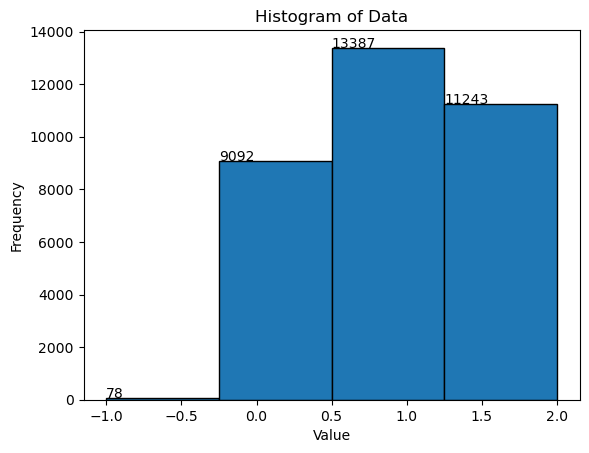

In [153]:
# Create a histogram to visualy see differences
import matplotlib.pyplot as plt

hist_values, bin_edges, _ = plt.hist(classes, bins=4, edgecolor='black')

# Add labels and a title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display frequency on top of each bar
for value, edge in zip(hist_values, bin_edges[:-1]):
    plt.text(float(edge), float(value), str(int(value)), color='black')
    
# Show the histogram
plt.show()


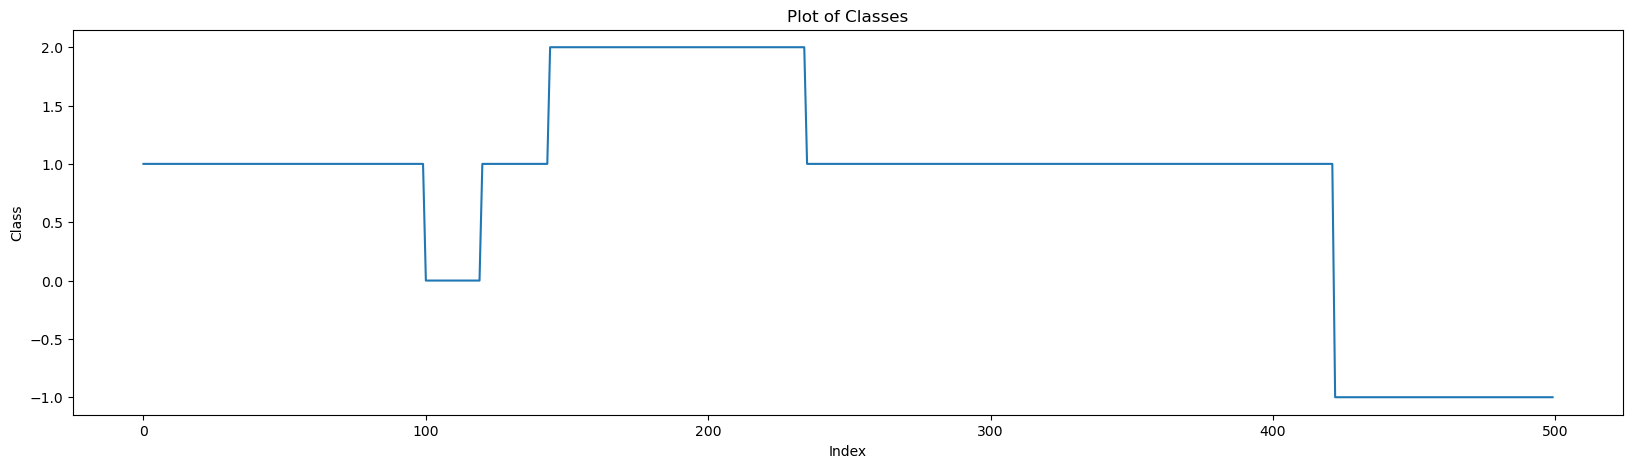

In [154]:
# Display classes value changes over time (last 500 ticks)
graph_ticks = 500
x = range(len(classes[-graph_ticks:]))

plt.figure(figsize=(20,5))
plt.plot(x, classes[-graph_ticks:], linestyle='-')


plt.xlabel('Index')
plt.ylabel('Class')
plt.title('Plot of Classes')

plt.show()

In [155]:

# Calculate the signals as input for the neural network as proportions
import preprocessing.proportions_calc as proportions

signals_calculator = proportions.ProportionsCalc(signal_avg)

proportions_avg = signals_calculator.calculate(close_prices)

In [157]:
print(f"Prices length: {len(close_prices)}")
print(f"Proportions length: {len(proportions_avg[-1])}")

print(f"Last 10 close: {close_prices[-10:]}")
print(f"Last 10 proportions(avg={signal_avg[0]}): {proportions_avg[0][-10:]}")

print(f"Proportions avgs: Count: {len(signal_avg)} Max: {signal_avg[-1]}")
# At the end of the data, when less ticks than necessary no possible to predict so "-1" 
print(f"Classes last non-negative-1: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]} len: {len(classes)}")
print(f"Proportions first non-negative-1(avg={signal_avg[-1]}): {proportions_avg[-1][signal_avg[-1]-2:signal_avg[-1]]} len: {len(proportions_avg[-1])}")
print(f"Proportions (avg={signal_avg[0]}) Min: {min(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT])}")
print(f"Proportions (avg={signal_avg[-1]}) Min: {min(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT])}")

Prices length: 33800
Proportions length: 33800
Last 10 close: [250.6, 250.715, 249.965, 249.415, 250.09, 250.605, 250.4, 250.4, 249.19, 248.5]
Last 10 proportions(avg=2): [0.001486432561780908, 0.0002293440758721968, -0.0015002100294749534, -0.001102580037358268, 0.0013495141748262583, 0.0010275134174588952, -0.00040934504799400464, -7.071375788794607e-14, -0.002427866286840148, -0.0013883299799505255]
Proportions avgs: Count: 16 Max: 2584
Classes last non-negative-1: [1, -1] len: 33800
Proportions first non-nan(avg=2584): [nan, -0.3989563404324635] len: 33800
Proportions (avg=2) Min: -1.9502283711002766 Max: 0.07537671689558442
Proportions (avg=2584) Min: -2.487705376731546 Max: 0.6134148294687672


In [159]:
# Removing the "-1" from the proportions
#   At the beging first signal_avg[-1] are "-1" (need previous values for first avg.)
#   At the end decided not predict if period to predict is shorter
targets = classes[signal_avg[-1]-1:-TICKS_PREDICT]
inputs = []
for proportion in proportions_avg:
    proportion_cut= proportion[signal_avg[-1]-1:-TICKS_PREDICT]
    print(proportion_cut[:2])
    inputs.append(proportion_cut)

print(f"First target: {targets[0]} and last target: {targets[-1]}")
print(f"Classes: {len(classes)} after cut to targets: {len(targets)}")
print(f"Inputs len: {len(inputs[len(signal_avg)-1])}")
print(f"Distinct targets: {list(set(targets))}")


[-0.001823468532850179, 0.004662630602477096]
[-0.0008049545775629514, 0.005012531328320961]
[0.000980730373074247, 0.007772678449372463]
[0.0061388053816968284, 0.012471316277707777]
[0.003065019353030941, 0.011862197952425409]
[9.739246346764442e-05, 0.009537991546585953]
[0.001919135403408614, 0.01055230704721967]
[-0.020603402314505005, -0.009848558823267527]
[-0.05768013604304566, -0.04632760582325515]
[-0.0883696042032875, -0.07744249015395718]
[-0.11992377854999434, -0.10859697596926905]
[-0.1566280904615039, -0.14540346871173945]
[-0.197081763618046, -0.1853820067520304]
[-0.2579944332754731, -0.24590435350998985]
[-0.309100243307088, -0.2966180668922108]
[-0.3989563404324635, -0.38572769513244454]
First target: 0 and last target: 1
Classes: 33800 after cut to targets: 31139
Inputs len: 31139
Distinct targets: [0, 1, 2]


In [160]:

from collections import Counter

print("Train data: '-1' removed from begining and end")
lu.display_frequency_classes(targets, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

targets_counter = Counter(targets)
count_remove_a= targets_counter[INDEX_REMOVE_A] - targets_counter[INDEX_KEEP] + targets_counter[INDEX_KEEP] //2
count_remove_b= targets_counter[INDEX_REMOVE_B] - targets_counter[INDEX_KEEP] + targets_counter[INDEX_KEEP] //2
print(f"Removing {INDEX_REMOVE_A}: {count_remove_a}")
print(f"Removing {INDEX_REMOVE_B}: {count_remove_b}")


Train data: 'nan' removed from begining and end
Total: 31139
 26.38%   8214 times   0% change (0)
 39.23%  12215 times   0% change (1)
 34.39%  10710 times 3.0% change (2)
Removing 1: 8108
Removing 2: 6603


In [88]:
###################
##### SET PARAMETERS
###################
# DECISION SET: REMOVING?
indexes_remove_a= []
# 2024-03-01 Do not remove anything
# if count_remove_a > 0:
#     indexes_remove_a = get_indexes_value(targets, index_remove_a, count_remove_a)

# DECISION SET: REMOVING?
indexes_remove_b= []
# 2024-03-01 Do not remove anything
# if count_remove_b > 0:
#     indexes_remove_b = get_indexes_value(targets, index_remove_b, count_remove_b)

indexes_remove= indexes_remove_a + indexes_remove_b
targets_clean= lu.remove_indexes(targets, indexes_remove)

lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)
print(f"Targets len: {len(targets)} Targets clean: {len(targets_clean)} Difference: {len(targets)-len(targets_clean)}")

inputs_clean = [lu.remove_indexes(input, indexes_remove) for input in inputs]    
print(f"targets_clean positions(Keep={INDEX_KEEP})(First:{targets_clean.index(INDEX_KEEP)},Last:-{targets_clean[::-1].index(INDEX_KEEP)})")


Total: 31139
 26.38%   8214 times -3.0% change (0)
 39.23%  12215 times   0% change (1)
 34.39%  10710 times 3.0% change (2)
Targets len: 31139 Targets clean: 31139 Difference: 0
targets_clean positions(Keep=0)(First:0,Last:-302)


In [89]:
# Sets 'index_keep' as target = 1 and rest of indexes to target=0
targets_binary= lu.convert_binary(targets_clean, INDEX_KEEP)
print(f"targets_binary First {targets_binary.index(True)} and Last(counting from end) {targets_binary[::-1].index(True)} position with True")
print(f"targets_binary len: {len(targets_binary)} Input clean[0]: {len(inputs_clean[0])} Input clean[-1]: {len(inputs_clean[-1])}")

targets_binary First 0 and Last(counting from end) 302 position with True
targets_binary len: 31139 Input clean[0]: 31139 Input clean[-1]: 31139


In [90]:
import torch

inputs_tensor = torch.Tensor(inputs_clean)
print(f"inputs_tensor: {inputs_tensor.size()}")
inputs_tensor = inputs_tensor.T
print(f"inputs_tensor: {inputs_tensor.size()}")
targets_tensor = torch.Tensor(targets_binary)
print(f"inputs_clean len0 x len1: {len(inputs_clean)} x {len(inputs_clean[0])} -> inputs_tensor.shape: {inputs_tensor.shape}")
print(f"targets_binary.shape: {len(targets_binary)} -> targets_tensor.shape: {targets_tensor.shape}")
print(f"inputs_tensor: {inputs_tensor}")
print(f"targets_tensor: {targets_tensor}")

inputs_tensor: torch.Size([16, 31139])
inputs_tensor: torch.Size([31139, 16])
inputs_clean len0 x len1: 16 x 31139 -> inputs_tensor.shape: torch.Size([31139, 16])
targets_binary.shape: 31139 -> targets_tensor.shape: torch.Size([31139])
inputs_tensor: tensor([[-1.8235e-03, -8.0495e-04,  9.8073e-04,  ..., -2.5799e-01,
         -3.0910e-01, -3.9896e-01],
        [ 4.6626e-03,  5.0125e-03,  7.7727e-03,  ..., -2.4590e-01,
         -2.9662e-01, -3.8573e-01],
        [-3.6644e-04,  2.6221e-03,  4.5341e-03,  ..., -2.4646e-01,
         -2.9728e-01, -3.8656e-01],
        ...,
        [ 8.4676e-04,  8.4352e-04,  1.1680e-05,  ...,  7.2783e-02,
          7.8101e-02,  6.0880e-02],
        [ 4.6674e-04,  1.1863e-03,  1.2524e-03,  ...,  7.3496e-02,
          7.8945e-02,  6.1739e-02],
        [-8.0838e-04, -7.6618e-04, -2.2596e-04,  ...,  7.1866e-02,
          7.7437e-02,  6.0205e-02]])
targets_tensor: tensor([1., 1., 1.,  ..., 0., 0., 0.])


In [91]:
#Shuffle tensors
torch.manual_seed(42) 
permutation = torch.randperm(inputs_tensor.size(0))
inputs_tensor_shuffle = inputs_tensor[permutation]

targets_tensor_shuffle = targets_tensor[permutation]

print(f"inputs_tensor.size(0): {inputs_tensor.size(0)}")
print(f"inputs_tensor.shape: {inputs_tensor.shape} -> inputs_tensor_shuffle.shape: {inputs_tensor_shuffle.shape}")
print(f"targets_tensor.shape: {targets_tensor.shape} -> targets_tensor_shuffle.shape: {targets_tensor_shuffle.shape}")

inputs_tensor.size(0): 31139
inputs_tensor.shape: torch.Size([31139, 16]) -> inputs_tensor_shuffle.shape: torch.Size([31139, 16])
targets_tensor.shape: torch.Size([31139]) -> targets_tensor_shuffle.shape: torch.Size([31139])


In [92]:

train_val_split= int(TRAIN_SPLIT * len(targets_tensor))
inputs_tensor_train, targets_tensor_train= inputs_tensor_shuffle[:train_val_split], targets_tensor_shuffle[:train_val_split]
inputs_tensor_val, targets_tensor_val= inputs_tensor_shuffle[train_val_split:], targets_tensor_shuffle[train_val_split:]


In [93]:
print("Training dataset frequencies:")
lu.display_frequency_values(targets_tensor_train.tolist())
print("Validation dataset frequencies:")
lu.display_frequency_values(targets_tensor_val.tolist())


Training dataset frequencies:
Total: 28025
 73.66%  20642 times (0.0)
 26.34%   7383 times (1.0)
Validation dataset frequencies:
Total: 3114
 73.31%   2283 times (0.0)
 26.69%    831 times (1.0)


In [94]:
from typing import Tuple
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets):
        
        self.inputs= inputs
        self.targets= targets

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        return self.inputs[index], self.targets[index]


In [95]:
# Multiplies the number of positive cases
class StockPositiveDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets,
        positive_mult=2
        ):
        
        self.inputs= inputs
        self.targets= targets
        self.positive_indices = [i for i, target in enumerate(targets) if target == 1]
        self.negative_indices = [i for i, target in enumerate(targets) if target == 0]

        self.balanced_indices = self.negative_indices + self.positive_indices * positive_mult

    def __len__(self) -> int:
        return len(self.balanced_indices)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        actual_index = self.balanced_indices[index]
        return self.inputs[actual_index], self.targets[actual_index]


In [96]:
from torch.utils.data import DataLoader


train_dataset= StockPositiveDataset(
  inputs_tensor_train,
  targets_tensor_train,
  POSITIVE_CASES_MULT
)

print(f"Length train_dataset: {len(train_dataset)}")

train_dataloader= DataLoader(
  dataset=train_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True
)

train_input0, train_target0= next(iter(train_dataloader))
print(f"train_input0: {train_input0} train_target0: {train_target0}")


Length train_dataset: 35408
train_input0: tensor([[-1.5276e-03, -2.7575e-03, -3.2832e-03,  1.6598e-04, -1.4508e-03,
         -1.4981e-02, -2.3431e-02, -2.6386e-02, -2.1149e-02, -3.1217e-02,
          2.0792e-02,  3.6613e-02, -1.1480e+00, -1.7396e+00, -1.9638e+00,
         -1.6270e+00],
        [-4.3976e-05,  2.4158e-03, -3.6096e-03, -7.9355e-03, -1.1303e-02,
         -1.4857e-02, -2.3250e-02, -2.7756e-02, -8.1912e-01, -1.3025e+00,
         -1.6458e+00, -1.8205e+00, -1.9252e+00, -1.8067e+00, -1.6682e+00,
         -1.7805e+00],
        [-2.8403e-03, -4.4804e-03, -6.9211e-03, -8.8583e-03, -9.6719e-03,
         -1.0723e-02, -1.8425e-02, -1.4205e-02, -9.6497e-03, -2.9768e-02,
         -4.0680e-02, -4.7065e-02, -1.8860e-02, -8.7021e-03,  2.2393e-02,
          1.5996e-02],
        [ 7.3890e-04, -1.4710e-03, -9.3121e-04, -1.2197e-03,  1.3937e-03,
          3.1590e-03,  5.2241e-03,  3.8610e-04, -1.5073e-02, -3.9598e-02,
         -6.3343e-02, -5.8000e-02, -3.5020e-02, -8.1211e-03, -4.4287e-02,
 

In [97]:
val_dataset= StockDataset(
  inputs_tensor_val,
  targets_tensor_val
)

print(f"Length val_dataset: {len(val_dataset)}")

val_dataloader= DataLoader(
  dataset=val_dataset,
  batch_size=BATCH_SIZE,
  shuffle=True
)

val_input0, val_target0= next(iter(val_dataloader))
print(f"val_input0: {val_input0} val_target0: {val_target0}")


Length val_dataset: 3114
val_input0: tensor([[-1.1817e-14, -1.0908e-15, -1.2726e-15,  1.9997e-15,  7.8172e-15,
          2.9087e-15, -2.3043e-03, -1.9580e-03,  1.1298e-03,  1.2250e-02,
          3.6773e-02,  4.6204e-02,  4.7950e-04, -5.7408e-02, -5.7123e-02,
         -1.4098e-01],
        [ 5.2436e-04, -9.4983e-04, -1.9802e-03, -1.4782e-03,  3.8181e-03,
          6.8440e-03,  8.4292e-03,  9.0880e-03,  4.1594e-03, -5.4978e-03,
          7.3977e-03,  2.7977e-02,  5.9786e-02,  6.7424e-02, -1.3838e-03,
          2.4925e-03],
        [ 1.6513e-03,  1.9840e-03,  8.5651e-04,  1.0238e-03, -2.4679e-03,
         -1.0394e-02, -1.7103e-02, -1.4369e-02, -1.1413e-02, -2.1203e-02,
         -3.6450e-02, -4.9876e-02, -3.9787e-02, -1.7780e-02, -1.0373e+00,
         -1.4432e+00],
        [ 1.2728e-03, -4.9732e-04, -2.7564e-03, -4.9526e-03, -1.0785e-02,
         -1.2644e-02, -1.3111e-02,  1.2618e-02,  7.2383e-02,  1.2144e-01,
          1.4266e-01,  2.6210e-02, -1.3517e-01, -2.8197e-01, -1.6682e-01,
      

In [98]:
# EXECUTE FROM THIS STEP To CREATE A NETWORK WITH RANDOM WEIGHTS

import torch
from torch import nn

class StockModelBinaryV0(nn.Module):
  def __init__(self, input_features, hidden_units):
    """Initializes multi-class classification model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units*16),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*8, out_features=hidden_units*4),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*4, out_features=hidden_units),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units, out_features=1)
    )

  def forward(self, x):
    # print("forward x: ",", ".join([str(num) for num in x.tolist()]))
    # Layers are defined inside the Sequencial NN and will be applied here.
    return self.linear_layer_stack(x)

# Create an instance of the model
model_0 = StockModelBinaryV0(
  input_features=len(signal_avg),
  hidden_units=HIDDEN_UNITS).to(device)


In [99]:
import torchmetrics

# loss_fn = nn.BCEWithLogitsLoss()

# Loss function for an imbalanced dataset (there many more 0's than 1's). Apply more weight to the less frequent class
num_ones = torch.count_nonzero(targets_tensor_train)
num_zeros = len(targets_tensor_train)-num_ones
pos_weight = num_zeros / (num_ones * POSITIVE_CASES_MULT)
print(pos_weight)
# pos_weight_tensor = torch.tensor([pos_weight]).to(device)
# pos_weight_tensor = torch.tensor([1.5]).to(device)
print(f"Train negative: {num_zeros} positive: {num_ones} pos_weight: {pos_weight}")

loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)


tensor(1.3979)
Train negative: 20642 positive: 7383 pos_weight: 1.3979412317276


In [100]:
###################
##### SET PARAMETERS
###################
# PERFORMANCE_MEASURE="accu"
# performance_fn= torchmetrics.Accuracy(task='binary').to(device)
PERFORMANCE_MEASURE="prec"
performance_fn= torchmetrics.Precision(task='binary').to(device)
# PERFORMANCE_MEASURE="reca"
# performance_fn= torchmetrics.Recall(task='binary').to(device)
###################
##### SET PARAMETERS
###################

In [101]:
# Should you reset BEST PERFORMANCE
best_val_performance = 0
model_best = None

In [102]:
###################
##### SET PARAMETERS
###################
# DO: AFTER THIS CELL RUNS EXECUTE CELLS UNTIL SAVE STEP TO KEEP BEST RESULT IN CASE IT GOES DOWN
#    lr = 0.1 -> 0.03 -> 0.001
#    epochs 200 + 200 (lr=0.1) -> 100 (lr=0.03) -> 100 (lr=0.001)
# EXECUTE 0.1 x 200 for 2 TIMES (or 400 for 1 time)
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)
# epochs=400
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.03)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.005)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0007)
# epochs=100
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.0001)
# epochs=100
###Using Adam optimizer
# learning_rate = 0.005
# beta_1 = 0.9
# beta_2 = 0.999
# decay = 0.01
# optimizer = optim.Adam(params=model_0.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=1e-8, weight_decay=decay)
# epochs=2000

EPOCHS=1000
LEARNING_RATE= 0.1
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=LEARNING_RATE)

##### Using a StepLR Scheduler
# from torch.optim.lr_scheduler import StepLR
# gamma = 0.95
# scheduler = StepLR(optimizer, step_size=20, gamma=gamma)
## If continue optimization
# learning_rate_last= 0.0080995 * 0.95
# gamma = 0.95
# optimizer = torch.optim.SGD(params=model_0.parameters(), lr=learning_rate_last*gamma)
# scheduler = StepLR(optimizer, step_size=20, gamma=gamma)
# epochs= 200

##### Using a ReduceLROnPlateau
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
###################
##### SET PARAMETERS
###################

In [103]:
from copy import deepcopy

EARLY_STOPPING_PATIENCE = 60

best_model_keep = "high_prec"
best_val_loss = float('inf')
early_stopping_counter = 0

for epoch in range(EPOCHS):
    train_loss, train_performance= 0, 0
    train_samples = 0

    # Training
    model_0.train()

    for batch, (X, y) in enumerate(train_dataloader):
        X= X.to(device)
        y= y.to(device)

        # Forward pass
        y_logits= model_0(X).view(-1)
        
        # turn logits -> prediction probabilities -> prediction labels
        y_sigmoid_output = torch.sigmoid(y_logits)
        y_pred = (y_sigmoid_output > TRAINING_THRESHOLD).float()
        
        # Calculate loss and accuracy
        loss= loss_fn(y_logits, y)
        train_loss+= loss * X.size(0)
        train_performance+= performance_fn(y_pred, y) * X.size(0)
        train_samples += X.size(0)
        
        # Zero the gradients to avoid accomulating gradients from previous iteration
        optimizer.zero_grad()
        
        # Backpropagation
        loss.backward()
        
        # Updates the model usign the gradients
        optimizer.step()
    
    train_loss /= train_samples
    train_performance /= train_samples
      
    model_0.eval()
    val_loss, val_performance= 0, 0
    val_samples = 0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X= X.to(device)
            y= y.to(device)
        
            # Predict for validation data
            val_logits= model_0(X).view(-1)
            sigmoid_output = torch.sigmoid(val_logits)
            val_pred = (sigmoid_output > TRAINING_THRESHOLD).float()
            
            # Calculate validation loss/accuracy
            val_loss+= loss_fn(val_logits, y) * X.size(0)
            val_performance+= performance_fn(val_pred, y) * X.size(0)
            val_samples += X.size(0)

        val_loss /= val_samples
        val_performance /= val_samples
    
    # Update the learning rate?
    if scheduler.__class__.__name__ == "ReduceLROnPlateau":
        scheduler.step(val_loss)
    else:
        scheduler.step()

    if epoch % 10 == 0:
       print(f"Epoch: {epoch+1} lr: {optimizer.param_groups[0]['lr']:.7f} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Val loss: {val_loss:.5f} Val {PERFORMANCE_MEASURE}: {val_performance*100:.4f}%")

    ## Store model with higher precision
    if best_model_keep == "high_prec" and val_performance > best_val_performance:
        best_val_performance = val_performance
        model_best = deepcopy(model_0)
            
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stopping_counter = 0
        #Store model with lower validation loss?
        if best_model_keep == "lower_loss":
            model_best = deepcopy(model_0)
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break    

print(f"Finished: Epoch: {epoch+1} lr: {optimizer.param_groups[0]['lr']:.7f} | Loss: {train_loss:.5f} {PERFORMANCE_MEASURE}: {train_performance*100:.4f}% | Val loss: {val_loss:.5f} Val {PERFORMANCE_MEASURE}: {val_performance*100:.4f}%")

Epoch: 1 lr: 0.1000000 | Loss: 0.75054 prec: 58.8552% | Val loss: 0.73257 Val prec: 37.8003%
Epoch: 11 lr: 0.1000000 | Loss: 0.60336 prec: 69.2422% | Val loss: 0.56661 Val prec: 53.7225%
Epoch: 21 lr: 0.1000000 | Loss: 0.52024 prec: 72.2084% | Val loss: 0.76396 Val prec: 43.6636%
Epoch: 31 lr: 0.1000000 | Loss: 0.44139 prec: 74.8913% | Val loss: 0.38933 Val prec: 64.5503%
Epoch: 41 lr: 0.1000000 | Loss: 0.37411 prec: 78.7003% | Val loss: 0.31249 Val prec: 68.9251%
Epoch: 51 lr: 0.1000000 | Loss: 0.30493 prec: 82.8709% | Val loss: 0.43741 Val prec: 61.1824%
Epoch: 61 lr: 0.1000000 | Loss: 0.24218 prec: 86.8325% | Val loss: 0.20095 Val prec: 84.0093%
Epoch: 71 lr: 0.0500000 | Loss: 0.14388 prec: 92.0931% | Val loss: 0.12261 Val prec: 87.4063%
Epoch: 81 lr: 0.0250000 | Loss: 0.08043 prec: 95.2016% | Val loss: 0.07411 Val prec: 92.6751%
Epoch: 91 lr: 0.0125000 | Loss: 0.04854 prec: 97.1492% | Val loss: 0.05728 Val prec: 92.5559%
Epoch: 101 lr: 0.0125000 | Loss: 0.04750 prec: 97.1594% | Val

Validation loss: 0.03865 Performance prec: 97.3715668%
Train validation confusion matrix:
tensor([[2261,   22],
        [  16,  815]])
Train validation accuracy: 98.78%
Train validation precision: 97.37%
Val Precision manual: 97.37%
Val Recall manual: 98.07%


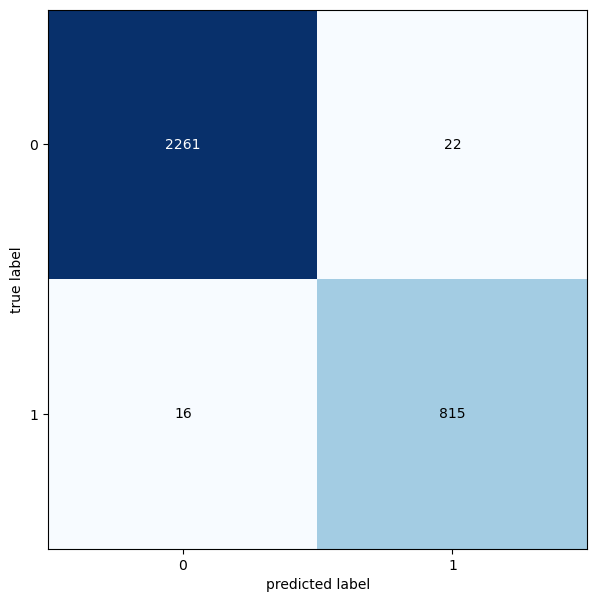

In [141]:
from torchmetrics import ConfusionMatrix, Accuracy, Precision
from mlxtend.plotting import plot_confusion_matrix

model_best.eval()
val_loss, val_performance= 0, 0
with torch.inference_mode():
    X= inputs_tensor_val.to(device)
    y= targets_tensor_val.to(device)

    # Predict for validation data
    val_logits= model_best(X).view(-1)
    sigmoid_output = torch.sigmoid(val_logits)
    val_pred = (sigmoid_output > TRAINING_THRESHOLD).float()
    
    # Calculate loss/performance(accuracy|precision)
    val_loss+= loss_fn(val_logits, y)
    val_performance+= performance_fn(val_pred, y)

print(f"Validation loss: {val_loss:.5f} Performance {PERFORMANCE_MEASURE}: {val_performance*100:.7f}%")

confmat= ConfusionMatrix(task='binary')

# vak_data.targets are the values we want to predict in the validation dataloader
confmat_tensor= confmat(
  preds= val_pred.cpu(),
  target= targets_tensor_val.cpu())

# Plot confusion matrix
fig, ax= plot_confusion_matrix(
  conf_mat= confmat_tensor.numpy(),
  figsize= (10, 7)
)

accuracy_fn= Accuracy(task='binary').to(device)
val_accuracy = accuracy_fn(val_pred, y)
print(f"Train validation confusion matrix:\n{confmat_tensor}")

precision_fn= Precision(task='binary').to(device)
val_precision = precision_fn(val_pred, y)
print(f"Train validation accuracy: {val_accuracy*100:.2f}%")
print(f"Train validation precision: {val_precision*100:.2f}%")
true_negative = confmat_tensor[0, 0].item()
false_positives = confmat_tensor[0, 1].item()
false_negatives = confmat_tensor[1, 0].item()
true_positives = confmat_tensor[1, 1].item()
precision_m  =true_positives / (true_positives + false_positives)
recall_m = true_positives / (true_positives + false_negatives)
print(f"Val Precision manual: {precision_m*100:.2f}%")
print(f"Val Recall manual: {recall_m*100:.2f}%")


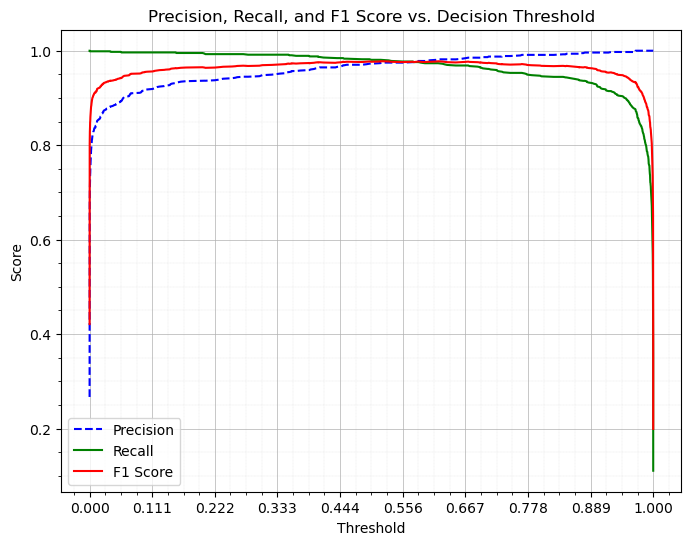

Val Threshold for max precision: 0.96852
Val Threshold for max recalls: 0.00000
Val Threshold for max f1_scores: 0.51638


In [145]:
# Calculate precision-recall curve
import numpy as np
from torchmetrics.classification import BinaryPrecisionRecallCurve

precision_recall_curve = BinaryPrecisionRecallCurve()

# Add predictions and targets
precision_recall_curve.update(val_logits.cpu(), targets_tensor_val.long())

# Compute precision-recall curve
precisions, recalls, thresholds = precision_recall_curve.compute()

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# Plot Precision-Recall curve with F1 scores
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
plt.plot(thresholds, f1_scores[:-1], 'r-', label='F1 Score')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score vs. Decision Threshold')
plt.legend(loc='best')
plt.xticks(np.linspace(0, 1, 10))
plt.grid(which='major', linestyle='-', linewidth=0.5)
plt.minorticks_on()
plt.grid(which='minor', linestyle='--', linewidth=0.2, alpha=0.5)
plt.show()

optimal_idx = np.argmax(precisions[:-1])
threshold_max_precision = thresholds[optimal_idx]
print(f"Val Threshold for max precision: {threshold_max_precision:.5f}")

optimal_idx = np.argmax(recalls[:-1])
threshold_max_recalls = thresholds[optimal_idx]
print(f"Val Threshold for max recalls: {threshold_max_recalls:.5f}")

optimal_idx = np.argmax(f1_scores[:-1])
threshold_max_f1_score = thresholds[optimal_idx]
print(f"Val Threshold for max f1_scores: {threshold_max_f1_score:.5f}")


#### Summary

In [146]:
import utils.text_utils as tu

date_start= df['date'][0]
date_end= df['date'].iloc[-1]

target= "UP" if PREDICT_UP else "DOWN"
MODEL_NAME= f"{datetime.now().strftime('%Y-%m-%d-%H%M')}-{TICKER}-predict{target}-dates{tu.shorten_date(date_start)}-{tu.shorten_date(date_end)}-days{DAYS_PREDICT}-down{int(DOWN_PCTS_PREDICT[0]*100)}-up{int(UP_PCTS_PREDICT[0]*100)}-in{len(signal_avg)}-hid{HIDDEN_UNITS}-pos_weight{pos_weight*10000:.0f}-{PERFORMANCE_MEASURE}{val_performance*10000:.0f}pct-fp{false_positives}tp{true_positives}-{best_model_keep}.pth"

print("======TRAINING:")
print(f"Ticker: {TICKER}")

print("--Data")
print(f"Start: {date_start} End: {date_end}")
print(f"Interval: {DATA_INTERVAL_MINUTES} - After Hours: {DATA_AFTER_HOURS}")
print("Targets Frequencies:")
lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

print(f"Signal Averages: {signal_avg}")
print(f"Train predict {'UP' if PREDICT_UP else 'DOWN'} - Days: {DAYS_PREDICT} Down pcts: {DOWN_PCTS_PREDICT} Up pcts: {UP_PCTS_PREDICT}")

print("Training dataset frequencies:")
lu.display_frequency_values(targets_tensor_train.tolist())
print("Validation dataset frequencies:")
lu.display_frequency_values(targets_tensor_val.tolist())

print("--Training")
print(f"Network hidden units: {HIDDEN_UNITS}")
print(f"Loss func: {loss_fn.__class__.__name__}")
print(f"Train negative: {num_zeros} positive: {num_ones} pos_weight: {pos_weight}")
print(f"Optimizer: {optimizer.__class__.__name__} Scheduler: {scheduler.__class__.__name__}")
print(f"Train/Val split: {TRAIN_SPLIT}")
print(f"Train threshold: {TRAINING_THRESHOLD}")
print(f"Positive cases multiplier: {POSITIVE_CASES_MULT}")
print(f"Epochs: {EPOCHS} learning_rate: {LEARNING_RATE}")
print(f"Trained model: {MODEL_NAME}")

print("--Validation Results")
print(f"Val loss: {val_loss:.5f} Performance {PERFORMANCE_MEASURE}: {val_performance*100:.2f}%")
print(f"Val confusion matrix:\n{confmat_tensor}")
print(f"Val accuracy: {val_accuracy*100:.2f}%")
print(f"Val precision: {val_precision*100:.2f}%")
print(f"Val false_positives: {false_positives} true_positives: {true_positives}")
print(f"Val Precision manual: {precision_m*100:.2f}%")
print(f"Val Recall manual: {recall_m*100:.2f}%")
print(f"Val F1-score manual: {2 * precision_m * recall_m / (precision_m + recall_m):.4f}")
print(f"Val Threshold for max precision: {threshold_max_precision:.5f}")
print(f"Val Threshold for max recalls: {threshold_max_recalls:.5f}")
print(f"Val Threshold for max f1_scores: {threshold_max_f1_score:.5f}")


======TRAINING:
Ticker: TSLA
--Data
Start: 2019-01-02 09:30:00-05:00 End: 2023-12-29 15:45:00-05:00
Interval: 15 - After Hours: False
Targets Frequencies:
Total: 31139
 26.38%   8214 times -3.0% change (0)
 39.23%  12215 times   0% change (1)
 34.39%  10710 times 3.0% change (2)
Signal Averages: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]
Train predict DOWN - Days: 3 Down pcts: [3.0] Up pcts: [3.0]
Training dataset frequencies:
Total: 28025
 73.66%  20642 times (0.0)
 26.34%   7383 times (1.0)
Validation dataset frequencies:
Total: 3114
 73.31%   2283 times (0.0)
 26.69%    831 times (1.0)
--Training
Network hidden units: 12
Loss func: BCEWithLogitsLoss
Train negative: 20642 positive: 7383 pos_weight: 1.3979412317276
Optimizer: SGD Scheduler: ReduceLROnPlateau
Train/Val split: 0.9
Train threshold: 0.5
Positive cases multiplier: 2
Epochs: 1000 learning_rate: 0.1
Trained model: 2024-06-02-1853-TSLA-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid1

In [111]:
# Saves model.state_dic() with best performance to a file

from pathlib import Path

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create path to the model
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# torch.save(
#   obj=model_0.state_dict(),
#   f=f"{MODEL_SAVE_PATH}.pth")

torch.save(
    obj=model_best.state_dict(), 
    f=f"{MODEL_SAVE_PATH}")


print(f"Trained model saved: {MODEL_NAME}")

Trained model saved: 2024-06-01-0656-TSLA-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight13979-prec9737pct-fp22tp815-high_prec.pth


In [ ]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary  


In [ ]:
summary(model_0, input_size=[len(signal_avg)])